In [1]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
from PIL import Image
import random

from sklearn.preprocessing import LabelEncoder

from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential

import tensorflow as tf

In [2]:
df=pd.read_csv("train.csv")
base_path = "./images/"

In [3]:
df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [4]:
samples = 20000
df = df.loc[df["id"].str.startswith('00', na=False), :]
#df = df.loc[:samples, :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [5]:
print(f"Number of classes: {num_classes}")

Number of classes: 5346


In [6]:
print(f"Number of data points: {num_data}")

Number of data points: 6120


In [7]:
data = pd.DataFrame(df["landmark_id"].value_counts())

data.reset_index(inplace=True)
data.columns=['landmark_id','count']
data.head()

,landmark_id,count
0,138982,31
1,83144,14
2,126637,7
3,194914,7
4,109169,6


In [8]:
data.tail()

,landmark_id,count
5341,71434,1
5342,71336,1
5343,71228,1
5344,71145,1
5345,202981,1


In [9]:
data['count'].describe()

count    5346.000000
mean        1.144781
std         0.641260
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        31.000000
Name: count, dtype: float64

(array([5.344e+03, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

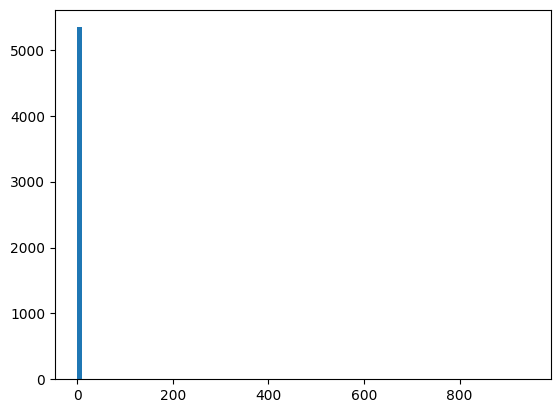

In [10]:
plt.hist(data['count'], 100, range = (0,944), label='test')

In [11]:
print(f"Count of landmark IDs with 0-5 occurrences: {data['count'].between(0, 5).sum()}")

Count of landmark IDs with 0-5 occurrences: 5339


In [12]:
print(f"Count of landmark IDs with 5-10 occurrences: {data['count'].between(5, 10).sum()}")

Count of landmark IDs with 5-10 occurrences: 14


(array([2., 1., 1., ..., 1., 1., 2.]),
 array([2.70000e+01, 6.00000e+01, 1.24000e+02, ..., 2.02950e+05,
        2.02972e+05, 2.02981e+05]),
 <BarContainer object of 5345 artists>)

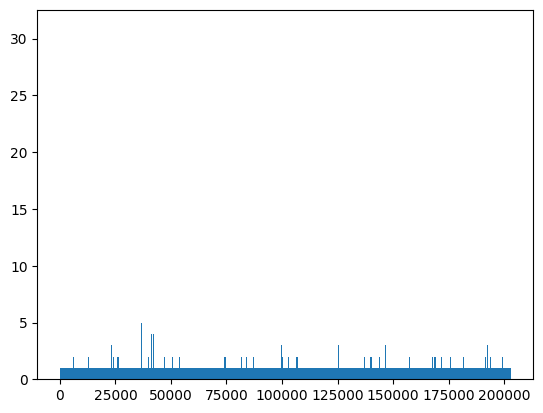

In [13]:
plt.hist(df["landmark_id"], bins=df["landmark_id"].unique())

In [14]:
#Training of Model

lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [15]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [16]:
def encode_label(lbl):
    return lencoder.transform(lbl)

In [17]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [18]:
def get_image_from_number(num, df):
    row = df.iloc[num]
    fname = row['id'] + '.jpg'
    label = row['landmark_id']
    f1, f2, f3 = fname[0], fname[1], fname[2]
    path = os.path.join(base_path, f1, f2, f3, fname)
    im = cv2.imread(path)
    if im is None:
        print(f"Image not found: {path}")
    return im, label

4 sample images from random class


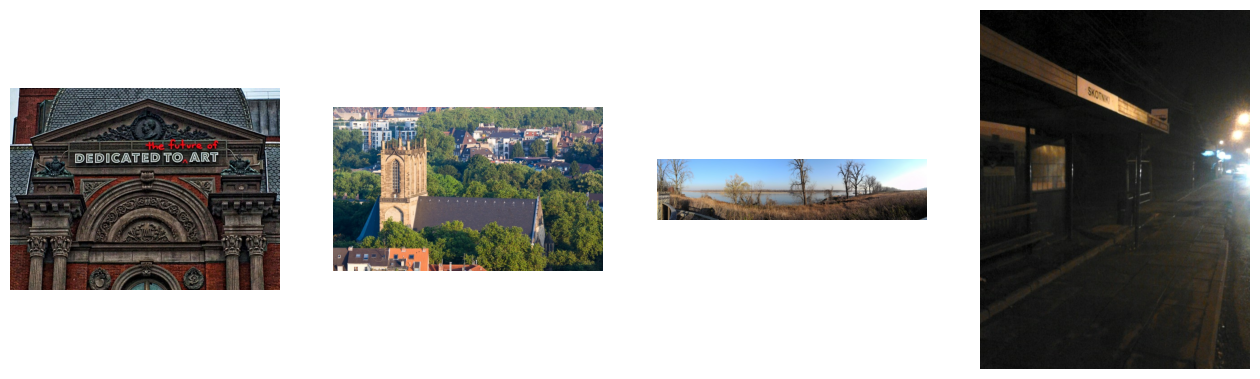

In [19]:
print("4 sample images from random class")
fig = plt.figure(figsize=(16, 16))
for i in range(1, 5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = os.path.join(base_path, ri[0], ri[1], ri[2])
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(os.path.join(folder, random_img)))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [20]:
#tf.compat.v1.disable_eager_execution()

In [21]:
#parameters
learning_rate = 0.1
decay_speed = 1e-6
momentum = 0.09
loss_function = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))
#drop_layer = Dropout(0.5)
#drop_layer2 = Dropout(0.5)

In [22]:
model = Sequential()
for layer in source_model.layers:
    model.add(layer)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5346)           │   134,125,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,150,178 (588.04 MB)

 Trainable params: 154,150,178 (588.04 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
optim1 = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optim1, loss=loss_function, metrics=["accuracy"])

In [24]:
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)


In [25]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []

    end_img = start + batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)

    for idx in range(start, end_img):
        im, label = get_image_from_number(idx, dataframe)
        if im is not None:
            im = image_reshape(im, (224, 224)) / 255.0
            image_array.append(im)
            label_array.append(label)

    label_array = lencoder.transform(label_array)
    return np.array(image_array), np.array(label_array)

In [26]:
batch_size = 16
epoch_shuffle = True
weight_class = True
epochs = 1

#split
train, val = np.split(df.sample(frac=1), [int(0.8 * len(df))])
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")

Training set size: 4896
Validation set size: 1224


In [27]:
for e in range(epochs):
  print("Epoch :" + str(e+1) + "/" + str(epochs))
  if epoch_shuffle:
    train = train.sample(frac = 1)
  for it in range(int(np.ceil(len(train)/batch_size))):
    X_train, y_train = get_batch(train, it*batch_size, batch_size)
    # No need to convert to NumPy array
    model.train_on_batch(X_train, y_train)

model.save("Model")

Epoch :1/1


In [27]:
batch_size = 16

errors = 0
good_preds = []
bad_preds = []

num_val_batches = int(np.ceil(len(val) / batch_size))  # Calculate total number of batches needed

for it in range(num_val_batches):
    start_idx = it * batch_size
    end_idx = min((it + 1) * batch_size, len(val))  # Ensure not to exceed the number of validation samples

    X_val, y_val = get_batch(val, start_idx, batch_size)

    result = model.predict(X_val)
    cla = np.argmax(result, axis=1)
    
    for idx, res in enumerate(result):
        if start_idx + idx >= len(val):
            break  # Exit loop if we exceed the actual number of validation samples

        if cla[idx] != y_val[idx]:
            errors += 1
            bad_preds.append([start_idx + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([start_idx + idx, cla[idx], res[cla[idx]]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━

In [28]:
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse = True))

In [29]:
len(good_preds)

0

In [30]:
if len(good_preds) > 0:
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, 6):
        n = int(good_preds[i-1, 0])  # Access elements in good_preds correctly
        img, lbl = get_image_from_number(n, val)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(1, 5, i)
        plt.imshow(img)
        lbl2 = np.array(int(good_preds[i-1, 1])).reshape(1, 1)
        sample_cnt = list(df.landmark_id).count(lbl)
        plt.title("Label: " + str(lbl) + "\nClassified as: " + str(decode_label(lbl2)))
        plt.axis('off')
    plt.show()
else:
    print("No correct predictions (good_preds is empty).")


No correct predictions (good_preds is empty).
